In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import metrics as mt
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error as sk_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.max_columns = 100

## Dataset Overview and Problem Statement

> Give an overview of the dataset you have chosen to use.
>
>    - What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
>    - Who collected the data? Why? When?
>    - What evaluation criteria will you be using and why? 

For this lab, we will explore classifying the reactions of assays with chemical compounds and assign whether an assay is binding or non-binding based on the vector structure of a compound.  This exercise will be a multi-task classification where the "pref_name", or preferred target name, is the task.  Multi-task is most appropriate for this dataset as this dataset allows us to segregate targets and perform predictions on those targets.  Multi-modal is not an appropriate framework as this dataset does not support intuitive modes of data - think traditional modes such as audio, video, text, etc.  This dataset is tabled data.

This dataset is collected by and maintained by the European Molecular Biology Laboratory's European Bioinformatics Institue, EMBL-EBI.  The ChemBL dataset is a dataset containing molecules and various bio-properties of these molecules gathered while performing drug testing.  This dataset is primarily used to discover associations and reactions to certain assays which furthers drug development in the medical field.  In addition to qualitative and quantitative data about compounds, this dataset also includes compound structures (which can be converted into vectorized form as discovered in this exercise).

Evaluation Criteria:
    
- F1: This is our most important score as we can compare our generalized model to the averaged shared model F1 score.  Both precision and accuracy are equally important for this excercise as drug development and potential development funding will require as low as possible false positives and negatives in a prediction.  At the very least, this score should help assist a drug developer in assessing the binding affects of a compound.  Additionally, a large class imbalance influenced our decision to analyze F1 scores as we will want to prevent our model from generalizing a single class instance
    
- ROC/AUC: ROC is another metric used in support of F1 above.  This will be a supplemental evaluation criteria used to further enhance F1 analyses.  AUC will supplement ROC as a metric calculated during the ROC curve plotting.  ROC/AUC will not be the main focal point of our analysis because it will be challenging to compare a generalized model ROC curve to a shared model approach as each task is of a different length and therefore an average ROC curve via shared model will be challenging to create
    
- BEDROC: This is similar to ROC/AUC in all aspects - supplemental but challenging to compare between generalized and shared models.  However, this will give us a sniff test in how our model categorizes complex molecular structures.  BEDROC is fundamental in chemical analyses especially when it comes to determining activations.  A standard BEDROC score, with an alpha at 20, should be greater than 0.5.  Anything at or below 0.5 is no better than a coin flip.  We will be supplementing our F1 analyses by plotting and looking at BEDROC with an alpha of 20 and observing whether the BEDROC score surpasses the coin flip threshold
    
- McNemar Statistical Significance Testing: McNemar will be used to analyze statistical differences between models.  This test will be used to analyze and observe differences between what both models are predicting.

**Author's Notes: No team member is a subject matter expert in drug research or chemical compound structure fields.  Therefore, in order to attempt to solve this problem and analyze our model, some functions had to be consulted with and generated by ChatGPT.  Each piece of code generated by ChatGPT will be denoted with a comment: "CHATGPT GENERATED CODE".  We see this particularly relevent for BEDROC and fingerprinting.  With that said, the author's did not take ChatGPT output as true, but verified each aspect with multiple queries to ChatGPT (worded differently to get different results) as well as Google research on these topics.  We believe the help generated by ChatGPT is sound advice and have used it in our analysis.**

## Utility Functions
The following are utility functions used to help process and analyze the data

In [2]:
# CHATGPT GENERATED CODE
# Define a function to generate fingerprints
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
    features = np.zeros((1,))
    Chem.DataStructs.ConvertToNumpyArray(fp, features)
    return features

In [3]:
# CLASSROOM CODE
def step(key_order, opt, X_train, y_train, models_mtl):
    # accumulate all the operations for the dataset
    preds = {} 
    loss = {}  
    tapes = {} 
    
    for x in key_order:
        with tf.GradientTape() as tape:
            tapes[x[0]] = tape
            # make a prediction and calculate loss for each task
            preds[x[0]] = models_mtl[x[0]](X_train[x[0]])
            loss[x[0]] = mean_squared_error(y_train[x[0]], preds[x[0]])
            
    # now batch update all the models with the gradients
    for x in key_order:
        grads = tapes[x[0]].gradient(loss[x[0]], models_mtl[x[0]].trainable_variables)
        opt[x[0]].apply_gradients(zip(grads, models_mtl[x[0]].trainable_variables))

In [4]:
def roc_calc(model, X_test, y_test):
    yhat = model.predict(X_test)
    false_positive, true_positive, _ = mt.roc_curve(y_test.flatten(), yhat.flatten())
    roc = mt.auc(false_positive, true_positive)
    return false_positive, true_positive, roc

In [5]:
def precision_calc(true_positives, false_positives):
    return true_positives / (true_positives + false_positives)

In [6]:
def recall_calc(true_positives, false_negatives):
    return true_positives / (true_positives + false_negatives)

In [7]:
def f1_score_calc(precision, recall):
    return 2 * np.multiply(precision, recall)/np.add(precision, recall)

In [8]:
def avg_metric(scores, metric="precision"):
    # get the average precision for both the first DNN and the best NN
    metric_table = []
    for score in scores:
        if metric_table:
            metric_table = list(np.add(score[metric], metric_table))
        else:
            metric_table += score[metric]    
    metric_table = np.divide(metric_table,5)
    
    return metric_table

In [9]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

In [10]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["recall"])
    plt.ylabel('Recall')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_recall"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_f1 = []
    for score in scores:
        model_precision = sum(score["val_precision"])/len(score["val_precision"])
        model_recall = sum(score["val_recall"])/len(score["val_recall"])
        model_f1 = 2*model_precision*model_recall/(model_precision + model_recall)
        print(f"Model {model_} Validation F1:", model_f1)
        avg_val_f1.append(model_f1)
        model_ += 1
        
    print(f"Average Model Validation F1 Score:", sum(avg_val_f1)/len(avg_val_f1))

In [11]:
# this is taken from lecture and repurposed for this exercise
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = net.predict(X_test)
    yhat[yhat<0.5] = 0 
    yhat[yhat>=0.5] = 1
    print(yhat[yhat<=0.5])
    f1 = mt.f1_score(y_test.flatten(),yhat.flatten())
    # acc = mt.accuracy_score(y_test.flatten(),yhat.flatten())
    cm = mt.confusion_matrix(y_test,yhat)
    
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(df["standard_value_bin"]),yticklabels=np.unique(df["standard_value_bin"]))
    plt.title(title_text+'{:.4f}'.format(f1))

In [12]:
# CLASSROOM CODE
def step(key_order, opt, X_train, y_train):
    # accumulate all the operations for the dataset
    preds = {} 
    loss = {}  
    tapes = {} 
    
    for x in key_order:
        with tf.GradientTape() as tape:
            tapes[x] = tape
            # make a prediction and calculate loss for each task
            preds[x] = models_mtl[x](X_train[x])
            loss[x] = binary_crossentropy(y_train[x].reshape(-1, 1), preds[x])
            
    # now batch update all the models with the gradients
    for x in key_order:
        grads = tapes[x].gradient(loss[x], models_mtl[x].trainable_variables)
        opt[x].apply_gradients(zip(grads, models_mtl[x].trainable_variables))

In [40]:
# CHATGPT CODE
def bedroc_score_calc(y_true, y_pred, alpha=20):
    # Compute the number of actives and inactives
    n_actives = sum(y_true)
    n_inactives = len(y_true) - n_actives
    
    # Sort the molecules by predicted score
    indices = np.argsort(y_pred, axis=0)[::-1]
    ranked_predictions = y_true[indices]
    
    # Compute the BEDROC score
    total_weight = 0.0
    cumulative_sum = 0.0
    for i in range(len(y_true)):
        weight = 1.0 if i < (alpha * n_actives / len(y_true)) else 0.0
        cumulative_sum += ranked_predictions[i]
        total_weight += weight
    enrichment_factor = cumulative_sum / n_actives
    bedroc_score = enrichment_factor * total_weight / alpha
    return bedroc_score

## Dataset Preprocessing

MySQL Query used to create the "raw" data from chemBL - note that we do filter to IC50 standard type and nM for our standard units as our only transformations prior to bringing this data into a Python Environment.  We do this to limit the size of the data ingested.  Additionally, we select on choice columns from our first table (Activities) as these columns we believed to be most important and all other columns to be irrelevant or redundant.
```
SELECT  a.standard_value,
        b.le,
        d.target_type,
        d.pref_name,
        e.canonical_smiles,
        f.molecular_species
FROM chembl.activities a

inner join chembl.ligand_eff b
on a.activity_id = b.activity_id

inner join chembl.assays c
on a.assay_id = c.assay_id

inner join chembl.target_dictionary d
on d.tid = c.tid

inner join chembl.compound_structures e
on a.molregno = e.molregno

inner join chembl.compound_properties f
on a.molregno = f.molregno

where a.standard_type = 'IC50' and a.standard_units = 'nM' and (a.standard_value <= 300 or a.standard_value >= 10000);
```

In [14]:
# read in data
df = pd.read_csv("chemBL.csv")

In [15]:
# print length and show sample data
print(len(df))
df.head()

562960


,standard_value,le,target_type,pref_name,canonical_smiles,molecular_species
0,17000.0,0.20,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC...,NEUTRAL
1,180.0,0.25,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,NEUTRAL
2,29.4,0.43,SINGLE PROTEIN,Beta-1 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
3,30.8,0.43,SINGLE PROTEIN,Beta-2 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
4,120.0,0.56,PROTEIN COMPLEX GROUP,GABA-A receptor; anion channel,CCOC(=O)c1cn2c(n1)sc1ccccc12,NEUTRAL


In [16]:
# binarize ligand values based on ranges <=300 nM and >=10000 nM (1 for active, 0 for inactive respectively)
df.loc[df["standard_value"] <= 300.0, "standard_value_bin"] = 1
df.loc[df["standard_value"] >= 10000.0, "standard_value_bin"] = 0

>[1.0 points] How many tasks or modalities are there in the dataset and how do you define each task or modality? That is, explain if the task is within the same domain, cross domains, etc. If there are too many tasks or modalities to train the data reasonably, select a subset of the tasks for classification. For example, you might want to only train on 50 of the classification tasks.

The raw dataset contains about 4,000 tasks (not shown in this analysis).  However, our biggest issues before tasking are class imbalancing and class imbalancing within tasking.  In order to address both issues we identify a list of tasks where there is less than 20% of either class and filter these out.  20% is our threshold and is an assumption made into our data. 

Of this remaining dataset, there are 927 tasks.  These tasks are of the same domain - target names as it relates to compound reactivities.  For this exercise, we have reduced this down to 30 tasks.  Around the 30th task, each task will have about 1,000 records.  We determined this would be the limit to the amount of records that would be adequate for training and testing.  Therefore, we finalized our approach with using 30 tasks.  We lose ~32% of our data from the class balanced dataset described above, but we argue that the top 30 targets have enough datapoints to be worth training and testing our model.  Including more tasks would create sparsity within our dataset and model.  Including tasks with severe class imbalances will affect our model performance and create scenarios where the model will constantly predict a single class instead of generalizing.

After we have identified our tasks, we create the associated fingerprints to each SMILE (with the help of ChatGPT).  Finally, to prepare our model for consumption, we create an x_task_list and y_task_list to track our X and y datasets by task

(array([25370.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41950.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

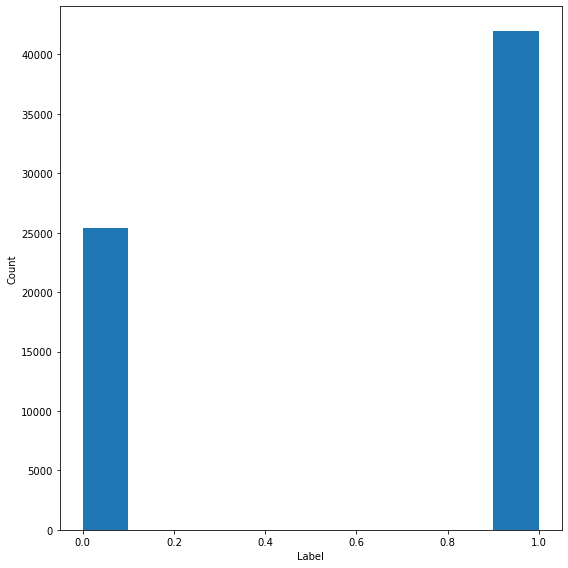

In [32]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [ ]:
# under sample datasets to address class imbalancing
y = df["standard_value_bin"]
X = df
del X["standard_value_bin"]
under_sample = RandomUnderSampler(sampling_strategy = 0.85)
X_under, y_under = under_sample.fit_resample(X, y)

# filter down the dataset
# df = pd.concat([X_under, y_under], axis=1)

In [18]:
# create a list of all targets that have at least 20% diversity in one of the output labels
target_name_filter = df.groupby("pref_name").agg({"standard_value_bin": sum, "target_type": "count"}).reset_index(drop=False)
target_name_filter = target_name_filter[target_name_filter["standard_value_bin"] > 0]
target_name_filter["proportion"] = target_name_filter["standard_value_bin"] / target_name_filter["target_type"]
target_name_filter = target_name_filter[(target_name_filter["proportion"] <= 0.8) & (target_name_filter["proportion"] >= 0.2)]

# filter down the dataframe
df = df[df["pref_name"].isin(target_name_filter["pref_name"])]


(array([54448.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 83549.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

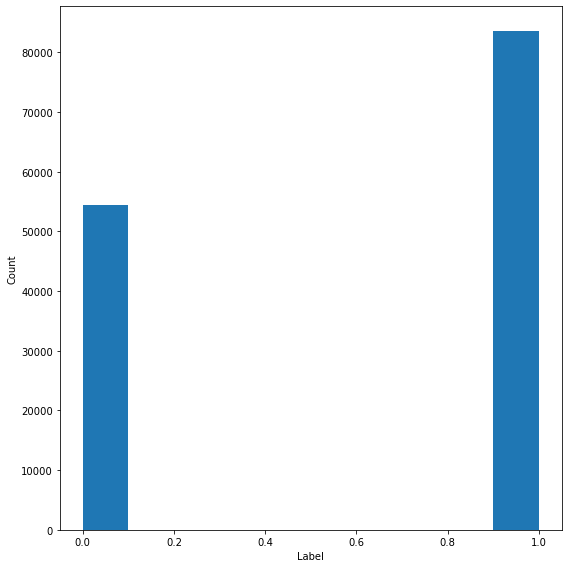

In [22]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [23]:
print("Total Number of Tasks: ", len(df["pref_name"].unique()))

Total Number of Tasks:  927


In [26]:
# determine the assay count by target name
targets = df.groupby("pref_name")[["target_type"]].agg({"target_type": "count"}).sort_values(by="target_type", ascending=False)
targets["cumulative_count"] = targets["target_type"].cumsum()
targets["cumulative_perc"] = targets["cumulative_count"]/sum(targets["target_type"])

# filter down df to top 100 targets
df = df[df["pref_name"].isin(targets.iloc[:30].index)]

In [27]:
print("Record count at the 100th target ", targets.iloc[30]["target_type"])

Record count at the 100th target  895.0


In [28]:
print("Cumulative Record Count in Reduced Dataset: ", targets["cumulative_perc"][30])

Cumulative Record Count in Reduced Dataset:  0.6775830899735781


(array([10860.,  3645.,  6678.,  7481., 10396.,  5352.,  6749.,  3780.,
         6466.,  5913.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

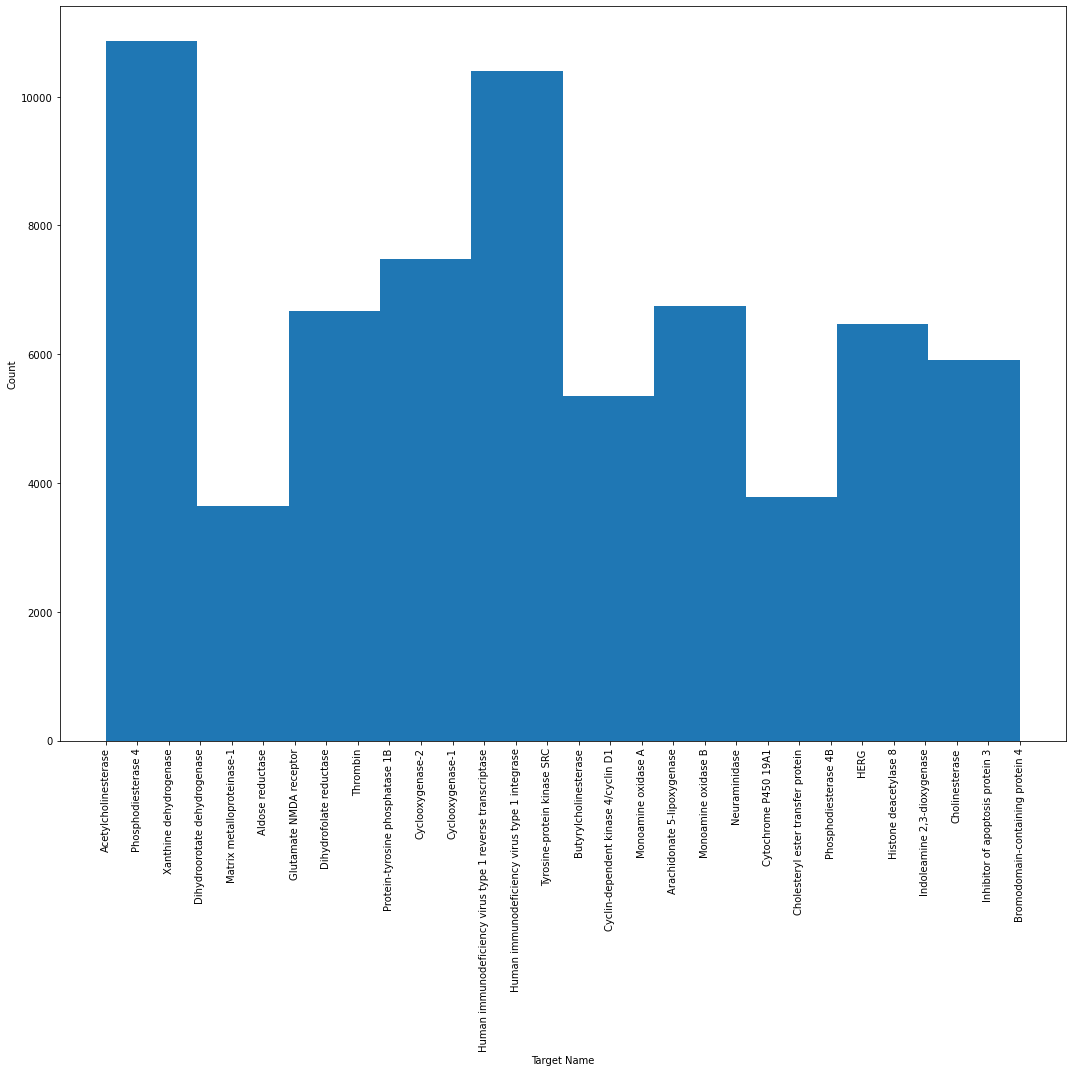

In [29]:
# plot out each set of tasks
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(15)
fig.set_figwidth(15)
axs.set_xlabel("Target Name")
axs.set_ylabel("Count")
plt.xticks(rotation=90)
axs.hist(df["pref_name"])

(array([25370.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41950.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

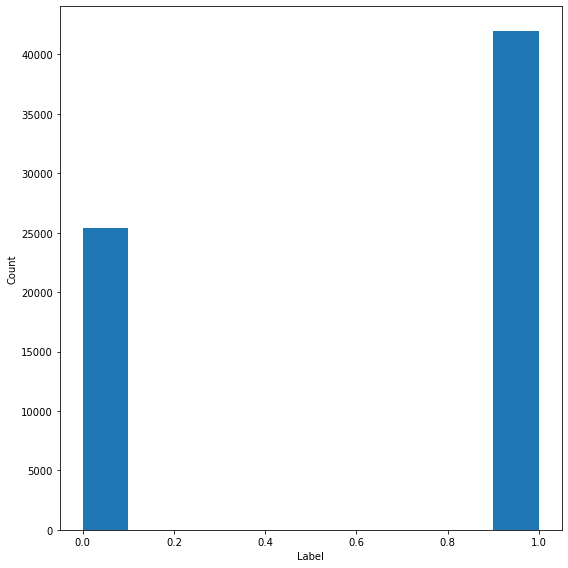

In [30]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [33]:
# Apply the function to each row of the DataFrame
df['Fingerprint'] = df["canonical_smiles"].apply(generate_fingerprint)

In [34]:
# initialize empty list of X and y values
task_X_list = []
task_y_list = []

# for each target, create a list of fingerprint values and associated labels
for target in df["pref_name"].unique():
    X = np.array(df[df["pref_name"] == target]["Fingerprint"].tolist())
    y = df[df["pref_name"] == target]["standard_value_bin"].values

    task_X_list.append((target, X))
    task_y_list.append((target, y))

>[1.0 points] Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

Since our dataset has ~65,000 records, we decided to split our data into 80% training, 20% testing. For the generalized model, we need to combine all of the tasks into a single task.  Of the 80% training data, we will perform another split using cross validation (CV).  We CV split the data 5 times, as we keep consistent with the above 80/20 method (5 splits means 4 are training, 1 is testing per iteration - or 80/20).  We use a K-Fold approach because K-Fold allows us to have an even 5-way split, keeping our training and validation data consistent with the above 80/20 rule.  We do not use a stratification approach because we "manually" balanced our classes to a more even class balance.  

For the shared model, we decided to split our data into 90% training and 10% testing.  Although inconsistent with the generalized model, we deem this important because of the sample population for many tasks being at aroun 1,000 samples.  Because of this low sample count for some tasks, we think a 90/10 split is most appropriate for this.  For each task, we will split on 10 to keep this consistent with the 90/10 split.  No stratification is required per task either due to how we handle class balances in the overall dataset.

In [36]:
all_data = {"data": [], "target": [], "data_test": [], "target_test": []}

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x,y in zip(task_X_list, task_y_list):
    X_train[x[0]], X_test[x[0]], y_train[x[0]], y_test[x[0]] = train_test_split(x[1], 
                                                                                y[1], 
                                                                                test_size=0.2, 
                                                                                random_state=7)
    
    all_data["data"].append(X_train[x[0]])
    all_data["target"].append(y_train[x[0]])        
    all_data["data_test"].append(X_test[x[0]])
    all_data["target_test"].append(y_test[x[0]])

X_train_all = np.concatenate(all_data["data"])
y_train_all = np.concatenate(all_data["target"])

X_test_all = np.concatenate(all_data["data_test"])
y_test_all = np.concatenate(all_data["target_test"])

>[3.0 points] Train a general model (or per task model) to perform the classification tasks. That is, a general model uses all modalities and all tasks should combined into a single classification task (if possible). Alternatively, if this is not possible, you could create a model for each specific task. For a task specific model, each task would be classified with its own feed-forward model.

Our first model approach is to create a general MLP in where we predict each compound structure reaction as non-binding (0) or binding (1).  We opt for a large model structure because we believe that more model parameters and layers will help generalize the model on our 2,048 feature vectors.  In terms of layer design, there is no empirical reason why we start our lower layer at 512 units, however, our philosophy is to decrease layer size for each additional layer by a factor of 2.  We want our layers to approach a smaller number of neurons as the layer count increases because our output is binary.  For activation, we chose ReLU because of the simplicity and our use-case of binary classification fits this activation function well without ghosting the gradients.  Droupout is used as a standard approach to curtail overfitting - previous iterations where we ran with no dropout, we experienced severe overfitting and we found that incorporating 20% dropout in most layers decreased overfitting.  Finally, our last layer has an activation of sigmoid as we found that sigmoid was the best activation for our use case - as opposed to softmax.

For our optimizer, we used ADAM as this is standard and safe to use for binary classification.  Our learning rate, we start at small to curtail above mentioned overfitting.  Our loss function is binary_crossentropy due to the nature of our dataset and labels being binary.  For metrics, we gather precision, accuracy, recall, and AUC for later analysis.

For this section, we will run the model and then elaborate on model analyses.

In [37]:
# initialize model
model = Sequential()

# add input layer plus dropout after first dense layer
model.add(Dense(input_dim=X_train_all.shape[1], units=512, activation='relu', name='input_dense512'))
model.add(Dropout(0.2))

# second layer
model.add(Dense(units=256, activation='relu', name='mid_dense256'))
model.add(Dropout(0.2))

# third layer
model.add(Dense(units=256, activation='relu', name='mid_dense2_216'))
model.add(Dropout(0.2))

# fourth layer
model.add(Dense(units=128, activation='relu', name='mid_dense128'))
model.add(Dropout(0.2))

# fifth layer
model.add(Dense(units=64, activation='relu', name='mid_dense64'))
model.add(Dropout(0.2))

# sixth layer
model.add(Dense(units=32, activation='relu', name='mid_dense32'))
model.add(Dropout(0.2))

# seventh layer
model.add(Dense(units=16, activation='relu', name='mid_dense16'))

# output layer
model.add(Dense(1, activation='sigmoid', name='output_layer'))

# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

# compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["Precision", "Recall", "Accuracy", "AUC", "binary_crossentropy"])



In [39]:
# select cross validation
cv = KFold(n_splits=5)

# initialize empty list of scores
model_scores = []

cv_split = 1

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train_all, y_train_all):
    
    print(f"On Split {cv_split}")

    # split dataset

    X_train_all_cv = X_train_all[train_index]
    y_train_all_cv = y_train_all[train_index]
    X_test_all_cv = X_train_all[test_index]
    y_test_all_cv = y_train_all[test_index]

    # fit the model
    model_history = model.fit(X_train_all_cv, y_train_all_cv, epochs=20, steps_per_epoch=int(len(X_train_all_cv)/32), 
                              shuffle=False, verbose=0, batch_size=32, validation_data=(X_test_all_cv,y_test_all_cv))

    # append scores
    model_scores.append(model_history.history)
    
    cv_split += 1

On Split 1
Epoch 1/20
1346/1346 [==============================] - 9s 6ms/step - loss: 0.6821 - precision: 0.6062 - recall: 0.9490 - Accuracy: 0.5956 - auc: 0.5191 - binary_crossentropy: 0.6821 - val_loss: 0.6780 - val_precision: 0.6935 - val_recall: 0.9997 - val_Accuracy: 0.6934 - val_auc: 0.5488 - val_binary_crossentropy: 0.6780
Epoch 2/20
1346/1346 [==============================] - 8s 6ms/step - loss: 0.6780 - precision: 0.6062 - recall: 0.9808 - Accuracy: 0.6024 - auc: 0.5328 - binary_crossentropy: 0.6780 - val_loss: 0.6689 - val_precision: 0.6935 - val_recall: 1.0000 - val_Accuracy: 0.6935 - val_auc: 0.5733 - val_binary_crossentropy: 0.6689
Epoch 3/20
1346/1346 [==============================] - 8s 6ms/step - loss: 0.6743 - precision: 0.6056 - recall: 0.9921 - Accuracy: 0.6039 - auc: 0.5390 - binary_crossentropy: 0.6743 - val_loss: 0.6592 - val_precision: 0.6935 - val_recall: 1.0000 - val_Accuracy: 0.6935 - val_auc: 0.6013 - val_binary_crossentropy: 0.6592
Epoch 4/20
1346/1346 [=

[0.843059778213501,
 0.8364322185516357,
 0.8375882506370544,
 0.8394615054130554,
 0.839317262172699,
 0.8405380249023438,
 0.8427290916442871,
 0.8425560593605042,
 0.8448334336280823,
 0.8478588461875916,
 0.8476691842079163,
 0.8511757254600525,
 0.851615309715271,
 0.8534616231918335,
 0.8544645309448242,
 0.8563671112060547,
 0.8576978445053101,
 0.8587523698806763,
 0.8602785468101501,
 0.8610273003578186]

In [63]:
# calculate the model avg validation precision, recall, and F1
model_avg_val_precision = avg_metric(scores=model_scores, metric="val_precision")
model_avg_val_recall = avg_metric(scores=model_scores, metric="val_recall")
model_f1 = f1_score_calc(precision=model_avg_val_precision, recall=model_avg_val_recall)

# calculate the final split F1
final_split_f1 = f1_score_calc(precision=model_scores[4]["val_precision"], recall=model_scores[4]["val_recall"])


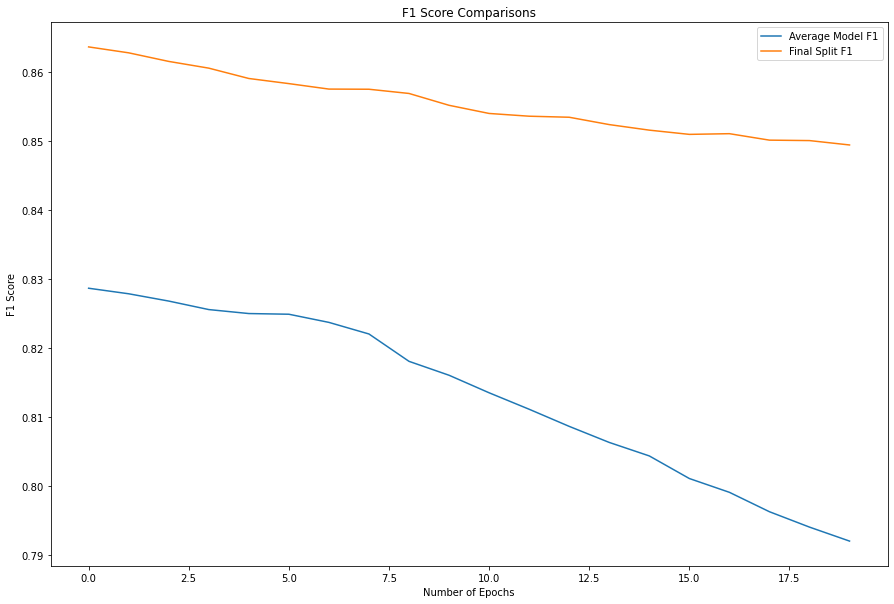

In [65]:
# plot out all model F1 scores
plt.figure(figsize=(15,10))
plt.title('F1 Score Comparisons')
plt.plot(model_f1)
plt.plot(final_split_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Average Model F1", "Final Split F1"])

Our team observed that this F1 score, although healthy, shows signs of possible overfitting as the trend downwards on both the Average Model F1 and the last CV split F1.

In [ ]:
# get the average AUC for all models
model_fp, model_tp, model_roc = roc_calc(model, X_test_all, y_test_all)

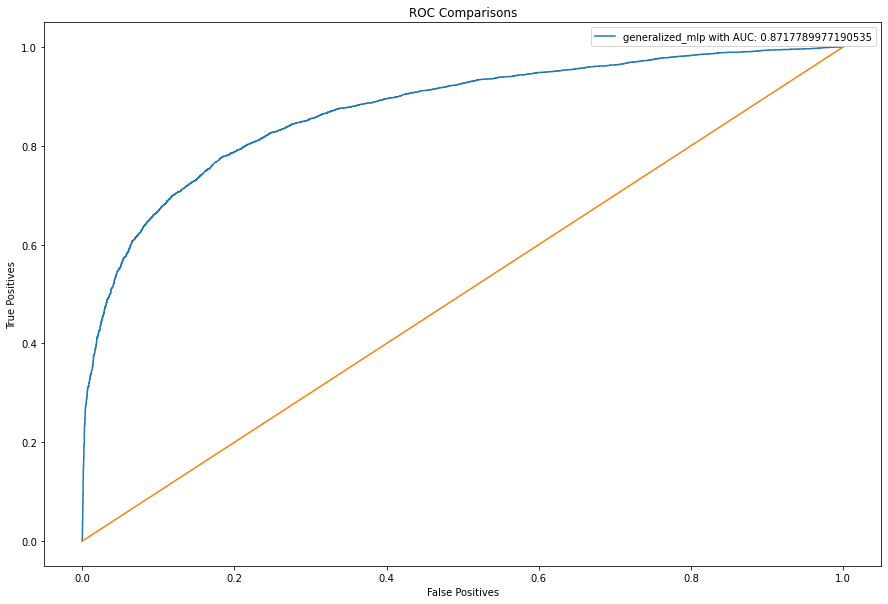

In [47]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(model_fp, model_tp)
plt.plot([0, 1])
plt.ylabel('True Positives')
plt.xlabel('False Positives')
plt.legend([f"generalized_mlp with AUC: {model_roc}"])

In the ROC Curve, we see a decently healthy curve that has about an 80% true positive rate for a 20% false positive rate.  The curve elbows off at around 75% to 85% true positive rate - this does not immediately inform us whether our model overfits or not, rather it does paint us a picture that our main evaluation criteria, F1, should be a healthy metric.  This curve indicates a good generalized model for our classification.

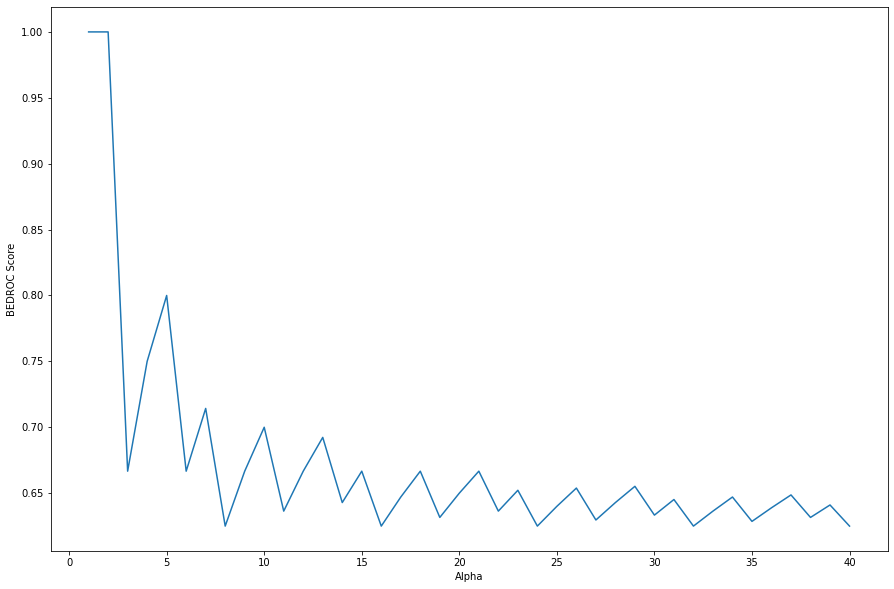

In [48]:
# predict out y
yhat = model.predict(X_test_all)

# CHATGPT CODE AS PART OF BEDROC_SCORE_CALC FUNCTION
# Generate a range of alpha values
alphas = np.linspace(1, 40, 40)

# Calculate BEDROC scores for each alpha value
bedroc_scores = []
for alpha in alphas:
    bedroc_score = bedroc_score_calc(y_true=y_test_all, y_pred=yhat, alpha=alpha)
    bedroc_scores.append(bedroc_score)

# Plot BEDROC curve
plt.figure(figsize=(15,10))
plt.plot(alphas, bedroc_scores)
plt.xlabel('Alpha')
plt.ylabel('BEDROC Score')
plt.show()

The BEDROC curve is not terrible but also not great.  Generally, if your BEDROC curve is greater than 0.6 at 20 alpha, it's considered passable by industry standards.  However, if the BEDROC fluctuates then this means that the model may be overfitting and that our model is not generalizing the top molecules accurately.  Because no team member is a SME in this field, we take this reading as cautionary rather than dismiss our model entirely.  We still have supporting evidence to suggest that our model can correctly generalize without predicting a singular classification.  Additionally, the BEDROC calculation may have errors as this was the team's first attempt at piecing together a BEDROC formula.  Overall, we agree that the BEDROC values at 20 alpha indicate a decently strong model, but that fluctuating trends can cause use to be concerned about the validity of classifications.

[0. 0. 0. ... 0. 0. 0.]


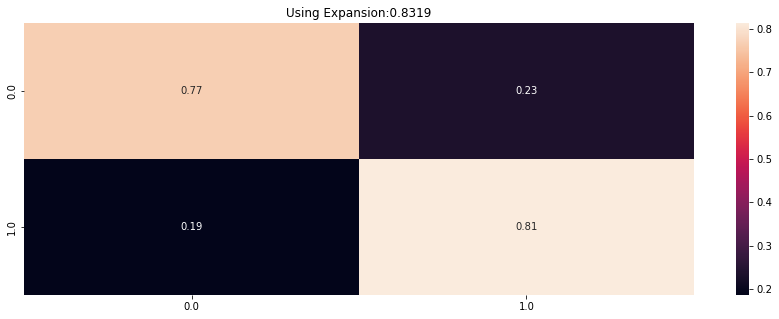

In [49]:
# summarize the last model to run
y_test_all.shape
summarize_net(model, X_test_all, y_test_all, title_text='Using Expansion:')

In [50]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(model, X_test_all, y_test_all)

[[3898 1192]
 [1565 6820]]
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      5090
         1.0       0.85      0.81      0.83      8385

    accuracy                           0.80     13475
   macro avg       0.78      0.79      0.79     13475
weighted avg       0.80      0.80      0.80     13475



Model 1 Validation F1: 0.8189891457754191
Model 2 Validation F1: 0.7702992561298803
Model 3 Validation F1: 0.8288485407985398
Model 4 Validation F1: 0.7526473241726913
Model 5 Validation F1: 0.8555546107176126
Average Model Validation F1 Score: 0.8052677755188287


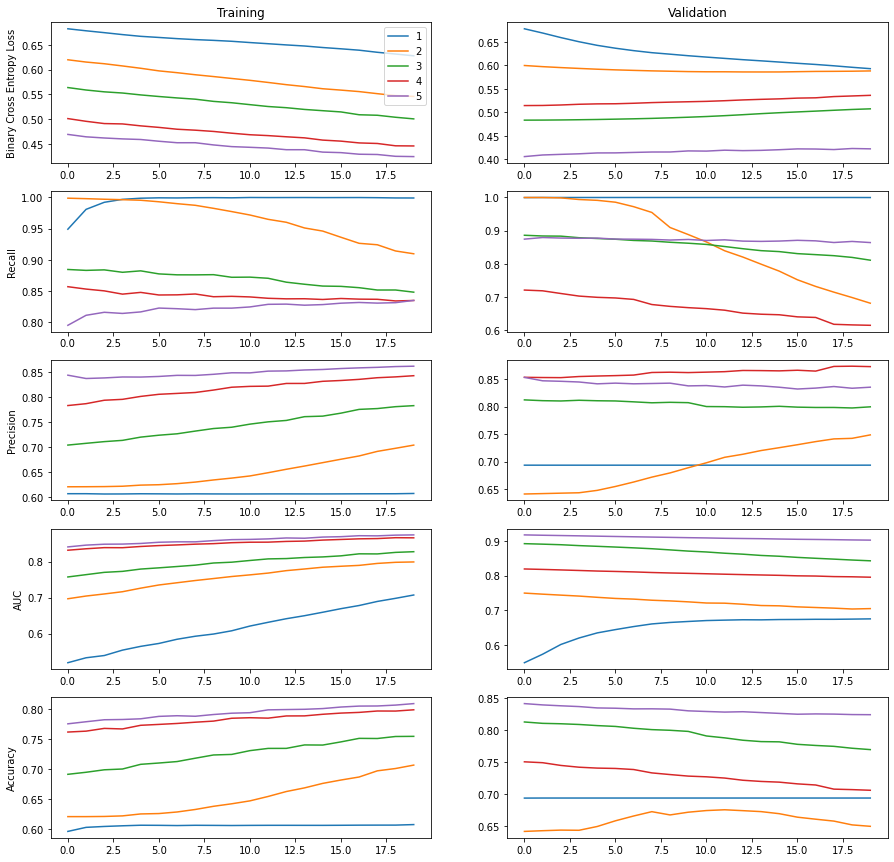

In [51]:
# plot supporting metrics
plot_metrics(model_scores)

The above 3 panels show additional supporting metrics that support our F1 scores above.  The confusion matrix shows that our model is not picking a single class to classify on and that there is a healthy spread of generalizations.  Model metrics such as Loss and Accuracy show that the risk of overfitting appears limited - as validation sets are decreasing with loss and increasing with accuracy for each split by each epoch.

>[3.0 points] Train a multi-task model (and/or) multi-modal model. You may use any method of multi-task or multi-modal training that you like.  For multi-task models, some fine tuning of the model should be attempted. For multi-modal models, some investigation of "where to merge" the modalities should be attempted. Be sure to look at the class demonstration example for code and hints. Feel free to use this code as a starting template.

For our multi-task model, we begin by extracting the weights from our generalized model.  Because these weights are pre-trained, we set these weights to non-trainable.  Next, we assign each of these weights to their respective layers in the new shared MLP model.  To keep things consistent, we design the same model structure with the same number of neurons per layer, the same number of layers, and the same activations per layer.  Finally, we construct our model while ensuring that no layers are trainable other than the final layer.  We do not add dropout.  We find this distinction important.  Dropout

### TODO: Maybe add dropout

In [ ]:
#get weights of generalized model
w1 = model.get_layer('input_dense512').get_weights()
w2 = model.get_layer('mid_dense256').get_weights()
w3 = model.get_layer('mid_dense2_216').get_weights()
w4 = model.get_layer('mid_dense128').get_weights()
w5 = model.get_layer('mid_dense64').get_weights()
w6 = model.get_layer('mid_dense32').get_weights()
w7 = model.get_layer('mid_dense16').get_weights()
w_output = model.get_layer('output_layer').get_weights()

# set these weights
inputs = Input(shape=(X_train_all.shape[1],))
shared_input = Dense(512, activation='relu', name = 'shared_input', trainable=False)(inputs)
shared_mlp_1 = Dense(256, activation='relu', name = 'shared_middle1', trainable=False)(shared_input)
shared_mlp_2 = Dense(256, activation='relu', name = 'shared_middle2', trainable=False)(shared_mlp_1)
shared_mlp_3 = Dense(128, activation='relu', name = 'shared_middle3', trainable=False)(shared_mlp_2)
shared_mlp_4 = Dense(64, activation='relu', name = 'shared_middle4', trainable=False)(shared_mlp_3)
shared_mlp_5 = Dense(32, activation='relu', name = 'shared_middle5', trainable=False)(shared_mlp_4)
shared_mlp_6 = Dense(16, activation='relu', name = 'shared_middle6', trainable=False)(shared_mlp_5)

# make a dictionary of models for each task
models_mtl = dict()

for x in task_X_list:
    # use same architecture as the general model, but 
    #. repeat the output layer for each school  
    output_layer = Dense(1, activation='sigmoid')(shared_mlp_6)
    model_task = Model(inputs=inputs, outputs=output_layer)

    models_mtl[x[0]] = model_task
    
    shared1 = models_mtl[x[0]].get_layer('shared_input')
    shared2 = models_mtl[x[0]].get_layer('shared_middle1')
    shared3 = models_mtl[x[0]].get_layer('shared_middle2')
    shared4 = models_mtl[x[0]].get_layer('shared_middle3')
    shared5 = models_mtl[x[0]].get_layer('shared_middle4')
    shared6 = models_mtl[x[0]].get_layer('shared_middle5')
    shared7 = models_mtl[x[0]].get_layer('shared_middle6')
    personal = models_mtl[x[0]].layers[-1]
    
    # set to be the weights from the general model, as starting point
    shared1.set_weights(w1) 
    shared2.set_weights(w2)
    shared3.set_weights(w3)
    shared4.set_weights(w4)
    shared5.set_weights(w5)
    shared6.set_weights(w6)
    shared7.set_weights(w7)
    personal.set_weights(w_output)
    shared1.trainable = False
    shared2.trainable = False
    shared3.trainable = False
    shared4.trainable = False
    shared5.trainable = False
    shared6.trainable = False
    shared7.trainable = False
    personal.trainable = True

In [ ]:
# Plot BEDROC curve
plt.figure(figsize=(15,10))
plt.plot(alphas, bedroc_scores)
plt.xlabel('Alpha')
plt.ylabel('BEDROC Score')
plt.show()

In [ ]:
%%time
EPOCHS = 20
X_keys = dict()
X_keys.update(X_train)
X_keys.update(X_test)

total_cfm_f1_by_epoch = []

opt = {} # need separate optimizers for each output task
for x in X_keys.keys():
    
    opt[x] = Adam() # track 

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
   # shuffle(all_keys) # shuffle in place operation, maybe not needed
    
    step(X_keys.keys(), opt, X_train, y_train) # batched gradient updates
    
    y_mtl=[]
    yhat_mtl=[]
    confusion_matrix = []

    for x in X_keys.keys():
        # test on data, for tracking
        yhat_mlp = models_mtl[x].predict(X_test[x],verbose=0)
        y_mtl.append(y_test[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())

        yhat_mlp_copy = yhat_mlp.copy()
        yhat_mlp_copy[yhat_mlp_copy<0.5] = 0 
        yhat_mlp_copy[yhat_mlp_copy>=0.5] = 1
        cfm = mt.confusion_matrix(y_test[x],yhat_mlp_copy).ravel()
        confusion_matrix.append(cfm)

    # sum total confusion matrix (tn, fp, fn, tp)
    total_cfm = sum(confusion_matrix)

    total_cfm_precision = precision_calc(total_cfm[3], total_cfm[1])
    total_cfm_recall = recall_calc(total_cfm[3], total_cfm[2])
    total_cfm_f1 = f1_score_calc(total_cfm_precision, total_cfm_recall)
    total_cfm_f1_by_epoch.append(total_cfm_f1)
    
    bce = binary_crossentropy(np.concatenate(y_mtl), np.concatenate(yhat_mtl)) #this should probably be bce or f1, not mse, just using for now
    print('...Binary Cross Entropy:',bce.numpy())

In [ ]:
total_cfm = total_cfm.reshape(2,2)
total_cfm = total_cfm/np.sum(total_cfm,axis=1)[:,np.newaxis]
sns.heatmap(total_cfm, annot=True, fmt='.2f', xticklabels=np.unique(df["standard_value_bin"]),yticklabels=np.unique(df["standard_value_bin"]))

In [ ]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(model_f1)
plt.plot(total_cfm_f1_by_epoch)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["General Model F1", "Shared Model F1"])

In [ ]:
bedroc_scores_mtl = {}
# for each task plot BEDROC
for task in range(len(y_mtl)):
    # CHATGPT CODE AS PART OF BEDROC_SCORE_CALC FUNCTION
    # Generate a range of alpha values
    alphas = np.linspace(1, 40, num=40)

    # Calculate BEDROC scores for each alpha value
    bedroc_scores = []
    for alpha in alphas:
        bedroc_score = bedroc_score_calc(y_true=y_mtl[task], y_score=yhat_mtl[task], alpha=alpha)
        bedroc_scores.append(bedroc_score)

    bedroc_scores_mtl[task] = bedroc_scores

In [ ]:
bedroc_scores_mtl = {}
# for each task plot BEDROC
for task in range(len(y_mtl)):
    # CHATGPT CODE AS PART OF BEDROC_SCORE_CALC FUNCTION
    # Generate a range of alpha values
    alphas = np.linspace(1, 40, num=40)

    # Calculate BEDROC scores for each alpha value
    bedroc_scores = []
    for alpha in alphas:
        bedroc_score = bedroc_score_calc(y_true=y_mtl[task], y_pred=yhat_mtl[task], alpha=alpha)
        bedroc_scores.append(bedroc_score)

    bedroc_scores_mtl[task] = bedroc_scores

In [ ]:
bedroc_scores_mtl_df = pd.DataFrame(bedroc_scores_mtl)

In [ ]:
from ipywidgets import interact, widgets

# create a function to plot the line chart with a slider
def plot_attribute(attribute):
    plt.plot(bedroc_scores_mtl_df[attribute])
    plt.xlabel('Data points')
    plt.ylabel('Attribute values')
    plt.title(attribute)

# create a slider widget to select the attribute
attribute_slider = widgets.SelectionSlider(
    options=bedroc_scores_mtl_df.columns,
    value=bedroc_scores_mtl_df.columns[0],
    description='Attribute:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# create an interactive plot using the slider
interactive_plot = interact(plot_attribute, attribute=attribute_slider)

# display the interactive plot
# plt.show()